# Setup

In [1]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from pprint import pprint
import colorama
colorama.init()

from os import listdir

import argparse
import os
import gc
import yaml
from loguru import logger
from datetime import datetime
from os import makedirs
from os.path import join, splitext, basename
from pprint import pformat
from typing import Union, Dict

import einops
import torch
torch.set_float32_matmul_precision("high")

from torch.utils.data import Subset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import Trainer
import wandb
wandb.require("core")

from utils import set_global_seed, get_k_fold_runs, get_loso_runs, get_simple_runs
from models.linear import Linear4EEG
from models.mlp import MLP4EEG
from models.dino4eeg import DINO4EEG
from datasets.base_class import EEGClassificationDataset
from models.base_model import EEGClassificationModel
from datasets.deap import DEAPDataset
from datasets.amigos import AMIGOSDataset
from datasets.grasp_and_lift import GraspAndLiftDataset
from datasets.high_gamma import HighGammaDataset

In [3]:
num_workers = os.cpu_count() // 2
with open(join("configs", cfg), 'r') as fp:
    args = yaml.safe_load(fp)
logger.info(f"args:\n{pformat(args)}")

# sets the random seed
set_global_seed(seed=args['seed'])

# sets the logging folder
datetime_str: str = datetime.now().strftime("%Y%m%d_%H:%M")
experiment_name: str = f"{datetime_str}_{args['dataset']}_size={args['windows_size']}_stride={args['windows_stride']}"
experiment_path: str = join(args['checkpoints_path'], experiment_name)
makedirs(experiment_path, exist_ok=True)

2024-09-16 16:17:01.374 | INFO     | __main__:<module>:4 - args:
{'batch_size': 128,
 'checkpoints_path': './checkpoints',
 'dataset': 'hg',
 'dataset_path': '../../datasets/hg',
 'device': 'auto',
 'hidden_size': 512,
 'k': 10,
 'lr': 0.001,
 'max_epochs': 50,
 'max_freq': 1000,
 'min_freq': 100,
 'model': 'mlp',
 'predict_ids': True,
 'seed': 42,
 'single_run': False,
 'train_perc': 0.8,
 'validation': 'simple',
 'windows_size': 1,
 'windows_stride': 1}


# PSDs

In [4]:
# sets up the dataset
if args["dataset"] == "deap":
    dataset_class = DEAPDataset
elif args["dataset"] == "amigos":
    dataset_class = AMIGOSDataset
elif args["dataset"] in {"grasp_and_lift", "gal"}:
    dataset_class = GraspAndLiftDataset
elif args["dataset"] in {"high_gamma", "hg"}:
    dataset_class = HighGammaDataset
else:
    raise NotImplementedError(f"unknown dataset {args['dataset']}")

Effective window size : 4.096 (s)


/home/rom42pla/repos/noisy_eeg/datasets/base_class.py:362: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.compute_psd().plot(xscale="log", axes=ax)


Plotting power spectral density (dB=True).


/home/rom42pla/repos/noisy_eeg/datasets/base_class.py:362: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot(xscale="log", axes=ax)
/home/rom42pla/repos/noisy_eeg/.conda/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


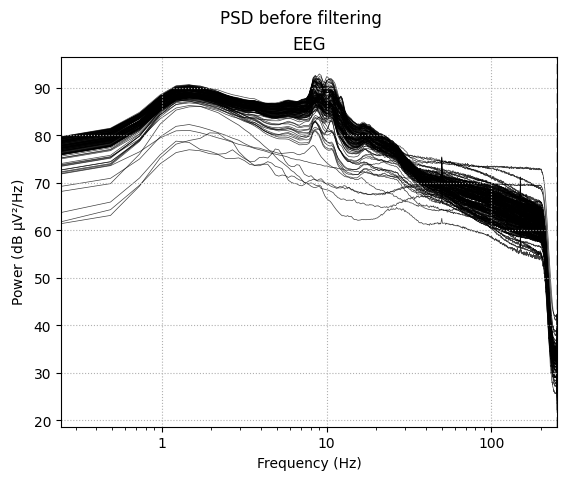

In [5]:
dataset_no_filter = dataset_class(
    path=args['dataset_path'],
    
    window_size=args['windows_size'],
    window_stride=args['windows_stride'],
    # min_freq=args["min_freq"],
    min_freq=0,
    max_freq=20000,
    drop_last=True,
    discretize_labels=True,
    normalize_eegs=True,
)
dataset_no_filter.plot_eeg_psd(title="PSD before filtering")
# dataset_no_filter.plot_eeg_psd(eeg_data=einops.rearrange(np.concatenate(
    # [eeg for eeg in dataset_no_filter.eegs_data], axis=0), "t c -> c t"), sampling_rate=dataset_no_filter.sampling_rate, title="PSD before filtering")
# del dataset_no_filter

Effective window size : 4.096 (s)


/home/rom42pla/repos/noisy_eeg/datasets/base_class.py:362: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.compute_psd().plot(xscale="log", axes=ax)


Plotting power spectral density (dB=True).


/home/rom42pla/repos/noisy_eeg/datasets/base_class.py:362: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot(xscale="log", axes=ax)
/home/rom42pla/repos/noisy_eeg/.conda/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


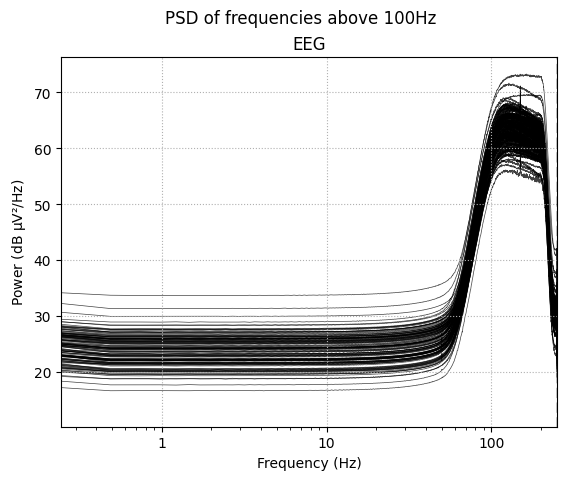

In [5]:
dataset_noeeg = dataset_class(
    path=args['dataset_path'],
    window_size=args['windows_size'],
    window_stride=args['windows_stride'],
    min_freq=100,
    max_freq=20000,
    drop_last=True,
    discretize_labels=True,
    normalize_eegs=True,
)
dataset_noeeg.plot_eeg_psd(title="PSD of frequencies above 100Hz")

Effective window size : 4.096 (s)


/home/rom42pla/repos/noisy_eeg/datasets/base_class.py:362: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.compute_psd().plot(xscale="log", axes=ax)


Plotting power spectral density (dB=True).


/home/rom42pla/repos/noisy_eeg/datasets/base_class.py:362: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot(xscale="log", axes=ax)
/home/rom42pla/repos/noisy_eeg/.conda/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


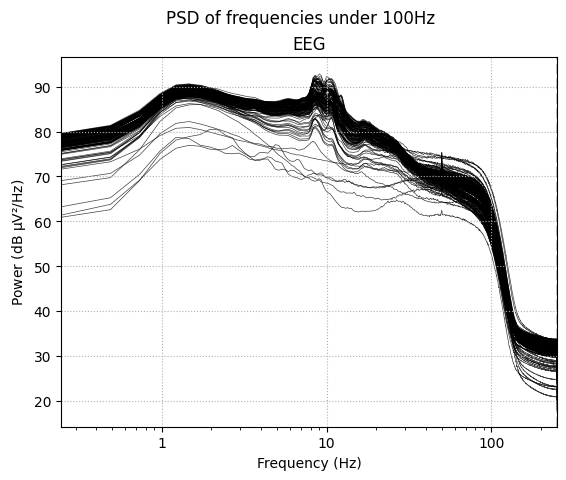

In [5]:
dataset_eeg = dataset_class(
    path=args['dataset_path'],
    window_size=args['windows_size'],
    window_stride=args['windows_stride'],
    min_freq=0,
    max_freq=100,
    drop_last=True,
    discretize_labels=True,
    normalize_eegs=True,
)
dataset_eeg.plot_eeg_psd(title="PSD of frequencies under 100Hz")